## Feature Selection

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# sklearn
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.feature_selection import RFE


# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader import DataLoader
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor

import warnings

warnings.filterwarnings('ignore')


1. Filter method
-  using correlation to identify important features
-  using mutual information (enthropy based)to identify imporatnt features

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DataLoader.get_top_feature

<function data_loader.DataLoader.get_top_feature(self, top_corr, mi_scores, X_filter_fs)>

1.1 Corrlation based feature selection 


(can be potentially better integrated with the EDA corrlation part)

In [4]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoader(args, post_eda=True)
df = data_loader.df

Datafile is already loaded.


In [5]:
# df_fs = data_loader.df

X_train_fs, X_test_fs, y_train_fs, y_test_fs = data_loader.get_raw_split_fs()
X_filter_fs = data_loader.data_prep(X_train_fs)


In [6]:
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=0.1),
            ElasticNet(alpha=0.1, l1_ratio=0.5),
            DTR(max_depth=10),
            RFR()]

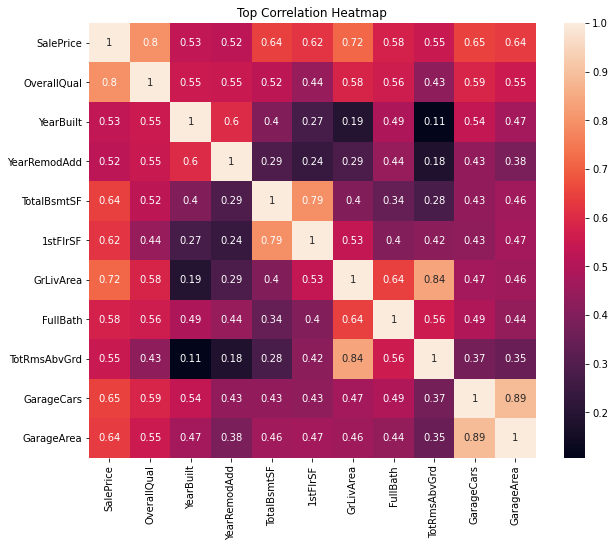

In [7]:
# get only the features with correlation above cutoff

def get_plot_heatmap_top(threshold=0.5):
    
    ''' 
    compute and plot the corr matrix with all top features 
    (correlation with saleprice above above thredshod)
    plot the correlation heatmap
    
    '''
    df_corr = y_train_fs.merge(
        X_train_fs, how="inner", left_index=True, right_index=True)

    corr_matrix = df_corr.corr()
    top_corr = corr_matrix[corr_matrix["SalePrice"] > threshold]
    top_corr = top_corr.loc[:, top_corr.index]

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(top_corr, annot=True)
    plt.title("Top Correlation Heatmap")

    return top_corr


top_corr = get_plot_heatmap_top()


1.2 Mutual Information based feature selection

In [8]:
#calculate mutual infomation and plot

def make_mi_scores(X, y,threshold=0.15):

    # All discrete features should now have integer dtypes

    mi_scores = mutual_info_regression(X, y,  random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores[mi_scores>threshold]
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    scores = scores
    width = np.arange(len(scores))
    ticks = list(scores.index)
    figure(figsize=(8,6),dpi=100)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


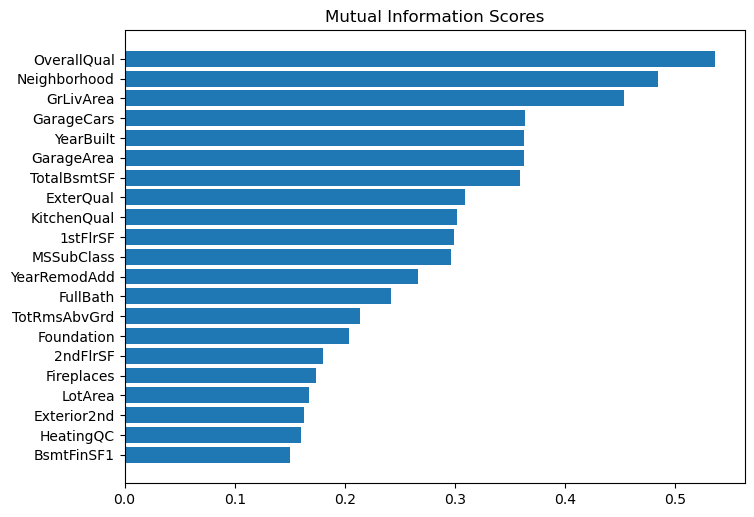

In [9]:
mi_scores = make_mi_scores(X_filter_fs, y_train_fs)
plot_mi_scores(mi_scores)

1.3 Merge to get the final filtered features

In [10]:
features_selected=data_loader.get_top_feature(top_corr, mi_scores, X_filter_fs)
X_train = data_loader.data_prep(X_train_fs[features_selected])
y_train = y_train_fs
X_test = data_loader.data_prep(X_test_fs[features_selected])
y_test = y_test_fs
features_selected


['Fireplaces',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'Exterior2nd',
 '2ndFlrSF',
 '1stFlrSF',
 'TotRmsAbvGrd',
 'GarageCars',
 'LotArea',
 'ExterQual',
 'GrLivArea',
 'Neighborhood',
 'MSSubClass',
 'Foundation',
 'FullBath',
 'KitchenQual',
 'YearBuilt',
 'YearRemodAdd',
 'GarageArea',
 'HeatingQC',
 'OverallQual']

1.4 Fit the new feature set to all the models and calculate the metric(RMSE)

In [11]:
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=1,max_iter=3000),
            ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=3000),
            DTR(max_depth=10),
            RFR(max_depth=10)
            ]

In [12]:
def analyze_regression(regressor):
    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train,np.ravel(np.array(y_train)))
    else: regressor.fit(X_train, y_train)

    # plot dignostics
    RMSE=mean_squared_error(y_test, regressor.predict(X_test),squared=False)
    plt.scatter(y_test, regressor.predict(X_test))

    print("For {model} the RMSE is {RMSE}".\
        format(model=regressor,RMSE=RMSE))


For LinearRegression() the RMSE is 31542.34555948344
For Ridge(alpha=1.5) the RMSE is 31516.065045079617
For Lasso(alpha=1, max_iter=3000) the RMSE is 31538.92198534322
For ElasticNet(alpha=0.1, max_iter=3000) the RMSE is 30764.263118679795
For DecisionTreeRegressor(max_depth=10) the RMSE is 37729.44341676373
For RandomForestRegressor(max_depth=10) the RMSE is 27037.413837687545


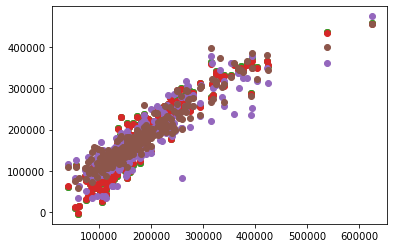

In [13]:
for regressor in regressor_list:

    analyze_regression(regressor)

In [14]:
# check the observed largest prediction errors (need more work)

# regressor = LinearRegressor()
# regressor.fit(X_train, y_train)

# y_predict_test = regressor.predict(X_test)
# df_decile = y_test.reset_index().merge(pd.DataFrame(y_predict_test, columns=["SalePricePredicted"]),
#                                        how="inner", left_index=True, right_index=True).set_index("index")
# # Calculate diff between predicted and actual for test dataset
# df_decile['diff'] = (df_decile.SalePrice-df_decile.SalePricePredicted)
# df_decile['diff_pct'] = (df_decile.SalePricePredicted/df_decile.SalePrice)-1
# df_decile = df_decile.reset_index().merge(X_train, how="inner", left_index=True,
#                                           right_index=True).set_index("index")
# pd.set_option('display.max_rows',
#               df.shape[0]+1), df_decile.sort_values(by='diff_pct').T

2. Wrapper method
recursive feature elemination process to identify features importance

In [15]:
#reset the data to all features
df_fs_w = data_loader.df
X_train_fs_w, X_test_fs_w, y_train_fs_w, y_test_fs_w = data_loader.get_raw_split_fs()


In [16]:
X_train = data_loader.data_prep(X_train_fs_w)
y_train = y_train_fs_w
X_test = data_loader.data_prep(X_test_fs_w)
y_test = y_test_fs_w


In [17]:

def rfe_fs(regressor, threshold=35):
    ''' Select the most important * features based on the model
         and use it as X_train & X_test'''
    selector = RFE(regressor, n_features_to_select=threshold, step=1)
    selector = selector.fit(X_train, y_train)
    selector_ind = selector.get_support()
    X_train_rfe = X_train.iloc[:, selector_ind]
    X_test_rfe = X_test.iloc[:, selector_ind]

    return X_train_rfe, X_test_rfe


In [18]:
def analyze_regression(regressor):

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train,np.ravel(np.array(y_train)))
    regressor.fit(X_train_rfe, y_train)
    predicted = regressor.predict(X_test_rfe)

    # plot dignostics

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    BaseRegressorPlot.plot_predicted_vs_actual(ax, predicted, y_test)
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe),squared=False)

    print("For {model} the RMSE is {RMSE}".\
    format(model=regressor,RMSE=RMSE))


In [19]:
regressor_list_2=[
    LinearRegression(),
    Ridge(alpha=1.5),
    Lasso(alpha=1,max_iter=5000),
    ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
    DTR(max_depth=10),
    RFR(max_depth=10)
    ]

For LinearRegression() the RMSE is 38633.079953377855
For Ridge(alpha=1.5) the RMSE is 39027.53642712506
For Lasso(alpha=1, max_iter=5000) the RMSE is 38558.299218185275
For ElasticNet(alpha=0.1, max_iter=5000) the RMSE is 37692.905315848635
For DecisionTreeRegressor(max_depth=10) the RMSE is 40562.984890938504
For RandomForestRegressor(max_depth=10) the RMSE is 28854.39661469482


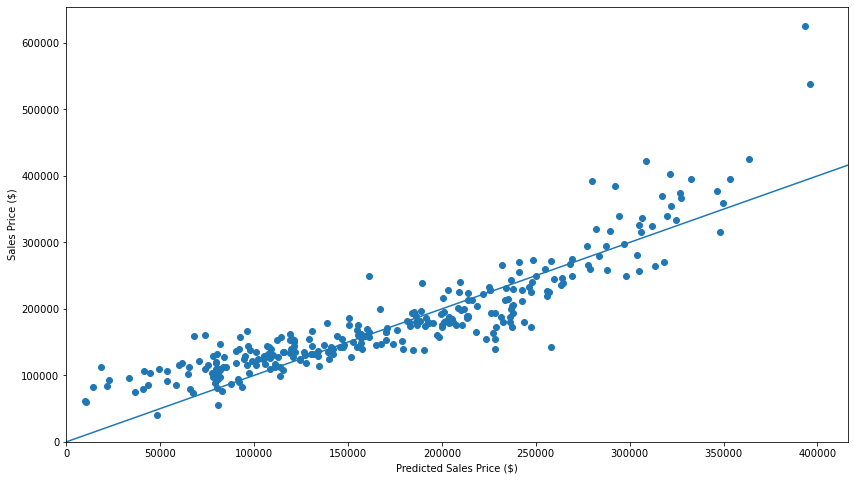

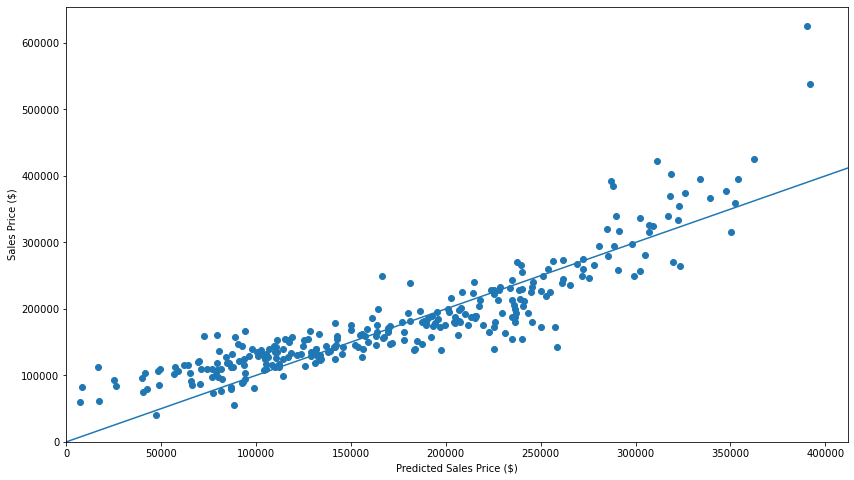

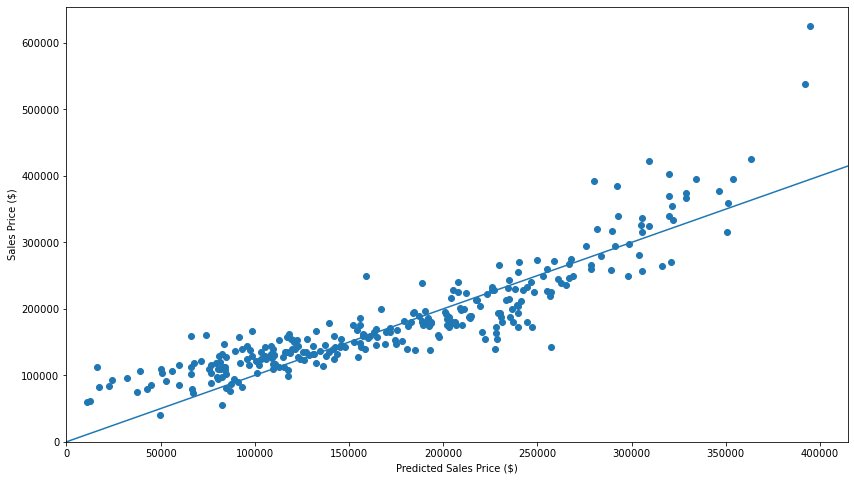

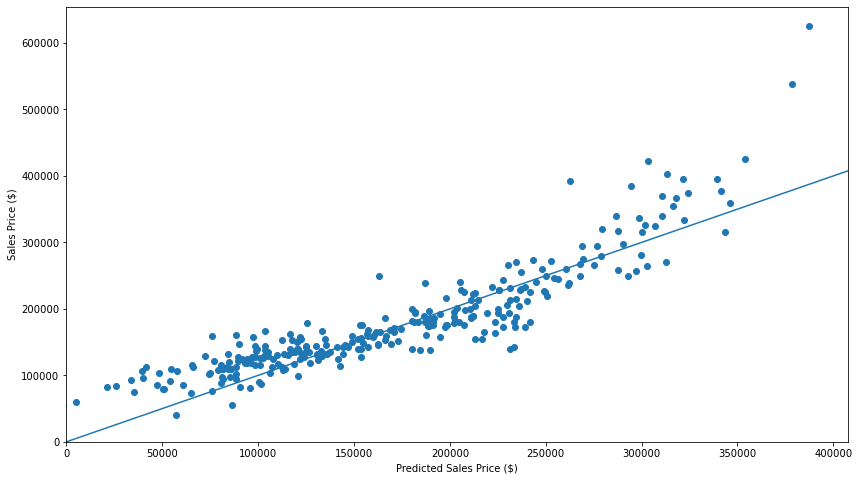

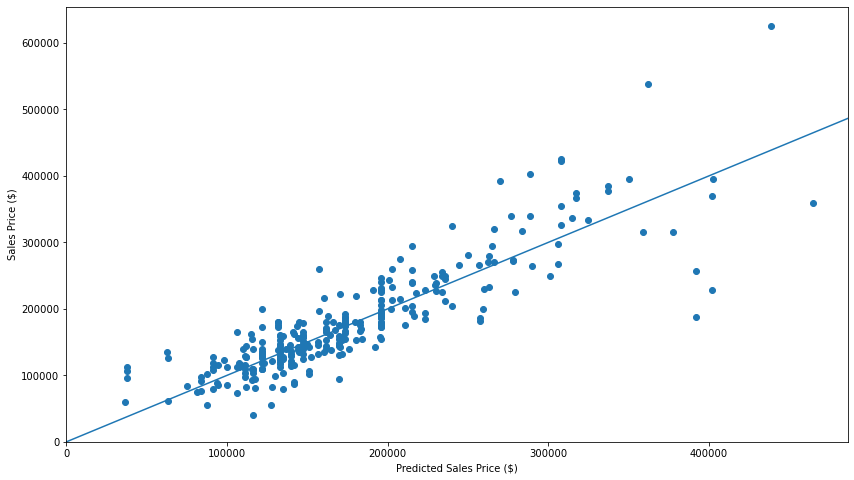

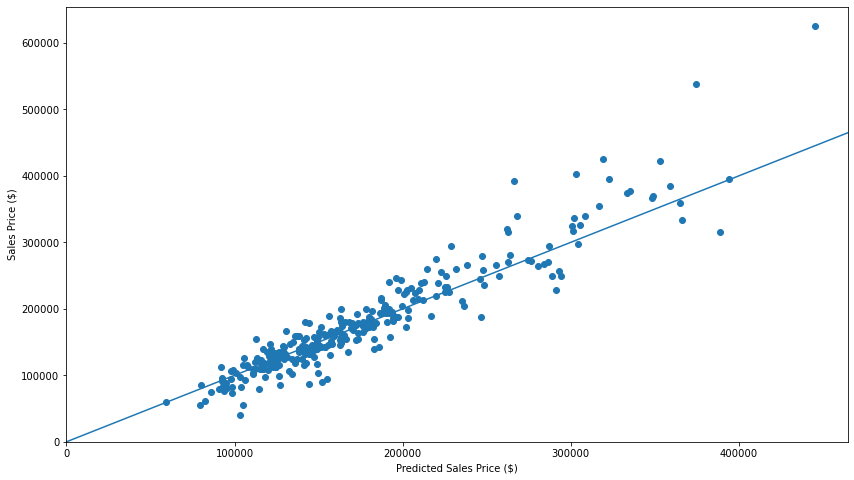

In [20]:
for regressor in regressor_list_2:

    analyze_regression(regressor)